# Set-up

## Package management

In [70]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Network science ---
from cdlib import algorithms
import networkx as nx

# --- Data handling and visualization ---

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# --- Project source code ---
sys.path.append("../")
sys.path.append("../src/")

# Data
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import lfr_multiplex  # benchmark samplers

# Sampling
from src.sampling.random import partial_information  # PFI observation

# Embedding
from src.embed.LE import LE

# Classifiers
from src.classifiers.features import *  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

# Utils
from src.utils.parameters import set_parameters_LE

## Global config

In [71]:
# * Pathing aliases
_ROOT = "../../"
_DATA = _ROOT + "data/input/"
_DFS = _ROOT + "results/dataframes/"
_FIGS = _ROOT + "results/plots/"

In [72]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green"]
markers_ = ["o", "s", "+", "^"]
viridis_ = mpl.colormaps['viridis']

---

# Experiment

## Function set-up

## Data set-up

### Specify parameters

In [79]:
_DATA_DICT = {
    "N": "number of nodes (in shared node set)",
    "GAMMA": "degree exponent of power-law degree distribution (from sampled distribution, finite sampling effects may yield different exponent if re-fit)",
    "MU": "mixing parameter for LFR model. Smaller MU implies (and is implied by) stronger modular structure.",
    "KMIN": "minimum degree (in either layer)",
    "KMAX": "maximum degree (in either layer)",
    "AVG_K": "average degree (in both layers)",
    "T1": "equivalent to GAMMA for LFR models",
    "T2": "community size power-law distribution exponent",
    "PROB": "relabeling probability. Controls correlation, with 0->1 = correlated->uncorrelated",
    "SIGN": "degree sequence sorting. Couples with PROB to produce anti/directly correlated degree sequences. -1 => anticorrelated, 1 => correlated"
}

In [80]:
class NetworkParams(Enum):
    # Shared params
    N = 1_000
    PROB = 1.0
    GAMMA = 2.1
    KMAX = np.sqrt(1_000)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    AVG_K = 10.0
    T2 = 4.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

In [81]:
class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 10, endpoint=True)

In [82]:
LOGREG = {"fit_intercept": True, "solver": "newton-cholesky", "penalty": None}

### Sample duplex

In [83]:
duplex, _, _, _ = lfr_multiplex(
    int(NetworkParams.N.value),  # number of nodes
    NetworkParams.GAMMA.value,  # degree distribution exponent
    NetworkParams.T2.value,  # community size distribution exponent
    NetworkParams.MU.value,  # community mixing parameter
    NetworkParams.AVG_K.value,  # average degree
    NetworkParams.KMAX.value,  # maximum degree
    NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
    NetworkParams.PROB.value,  # degree sequence correlation,
    ROOT="../"
)

In [84]:
G, H = duplex_network(duplex, 1, 2, verbose=True)

Number of common edges removed: 47
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


### Compute remnants

In [85]:
remnants = dict()  # theta -> [remnants infomation] mapping
for theta in ExperimentParams.THETAS.value:
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
    record = {
        "remnants": (remnant_G, remnant_H),
        "observed_edges": train_edges,
        "unobserved_edges": test_edges
    }
    remnants[theta] = record

## Feature calculation

In [86]:
features = dict()  # theta -> [train features, test features]
labels = dict()  # theta -> [train labels, test labels]

In [87]:
for theta, record in remnants.items():
    # --- Degree feature ---
    # Partially compute degree likelihood feature
    src_degrees_train, tgt_degrees_train = get_degrees(record["remnants"], list(record["observed_edges"].keys()))
    src_degrees_test, tgt_degrees_test = get_degrees(record["remnants"], list(record["unobserved_edges"].keys()))

    # Complete degree likelihood feature calculations
    feature_degrees_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
    feature_degrees_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

    # --- Embedding feature ---
    # & Embed remnants
    params, hyperparams, _ = set_parameters_LE(dimensions=2000)
    embeddings_G = LE(G, params, hyperparams["embedding"])
    embeddings_H = LE(H, params, hyperparams["embedding"])

    distances_G_train, distances_H_train = \
        get_distances((embeddings_G, embeddings_H), list(record["observed_edges"].keys()))
    distances_G_test, distances_H_test = \
        get_distances((embeddings_G, embeddings_H), list(record["unobserved_edges"].keys()))

    feature_distances_train = get_configuration_distances_feature(distances_G_train, distances_H_train, zde_penalty=0.1)
    feature_distances_test = get_configuration_distances_feature(distances_G_test, distances_H_test, zde_penalty=0.1)

    normalizer = max(
        np.abs(min(feature_distances_train)),
        np.abs(max(feature_distances_train)),
    )
    feature_distances_train = [x / normalizer for x in feature_distances_train]

    normalizer = max(
        np.abs(min(feature_distances_test)),
        np.abs(max(feature_distances_test)),
    )
    feature_distances_test = [x / normalizer for x in feature_distances_test]

    # --- Cleaning up features ---
    feature_matrix_train, feature_matrix_test = \
        format_feature_matrix(
            {"emb", "imb", "deg"},
            len(record["observed_edges"]), len(record["unobserved_edges"]),
            feature_distances_train, feature_distances_test,
            feature_degrees_train, feature_degrees_test
        )

    # --- Labels ---
    labels_train, labels_test = get_labels(record["observed_edges"], record["unobserved_edges"])

    # Save to feature and label mappings
    features[theta] = (feature_matrix_train, feature_matrix_test)
    labels[theta] = (labels_train, labels_test)

## Model training and evaluation

In [88]:
models = dict()  # theta -> [trained logistic regression]

In [89]:
for theta in ExperimentParams.THETAS.value:
    # Retrieve training labels
    Y = labels[theta][0]

    # Retrieve training features
    X = features[theta][0]

    # Format training features for scikit-learn models
    # X = np.array(X).reshape(-1,1)

    # Train model
    model = train_fit_logreg(X, Y, LOGREG)

    # Save to models mapping
    models[theta] = model

In [90]:
model_performances = dict()  # theta -> [performances]

In [91]:
for theta in ExperimentParams.THETAS.value:
    # Retrieve testing labels
    Y = labels[theta][1]

    # Retrieve testing features
    X = features[theta][1]

    # Format testing features for scikit-learn models
    # X = np.array(X).reshape(-1,1)

    # Apply model to test data
    model = models[theta]
    accuracy = get_model_accuracy(model, X, Y)
    auroc = get_model_auroc(model, X, Y)
    aupr = get_model_aupr(model, X, Y)
    performances = {
        "accuracy": accuracy,
        "auroc": auroc,
        "aupr": aupr,
    }

    # Save to models mapping
    model_performances[theta] = performances

# Analysis

Text(0.5, 1.0, 'Examining size effect with LE')

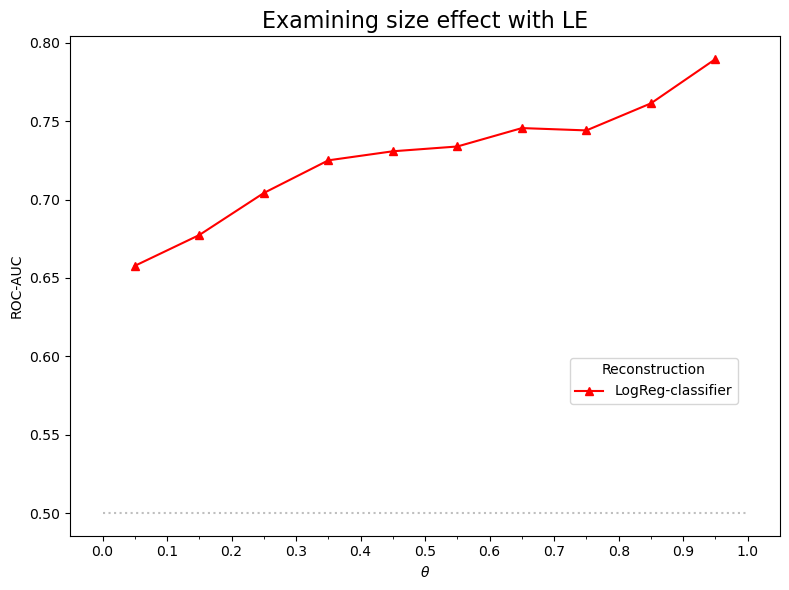

In [92]:
# Instantiate figure, subset relevant data
fig = plt.figure()

# Plotting data
X = sorted(model_performances.keys())
Y = [perfs["auroc"] for perfs in model_performances.values()]
plt.plot(
    X, Y,
    label="LogReg-classifier",
    color="red",
    marker="^"
)

plt.hlines(0.5, 0, 1, linestyles=":", color="gray", alpha=0.5)

# Axes configuration
ax = fig.axes[0]

plt.xticks(np.linspace(0, 1, 11))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")

# Figure-level attributes
plt.legend(title="Reconstruction", loc="lower right", bbox_to_anchor=(0.95, 0.25))
plt.title("Examining size effect with LE")

# Save plot
# plt.savefig(f"{_FIGS}/line_auroc-pfi_hue-method_walklength-20_EMBex35.png")